# Explore data augmentations

This notebook will be used to test different data augmentation strategies. In your config file, you can modify the augmentations by adding `data_augmentation_options`. For example, I would like to add a random RGB to gray transform with a probability of 0.2:
```
data_augmentation_options {
    random_rgb_to_gray {
    probability: 0.2
    }
```

A complete list of augmentation is provided the [`preprocessor.proto` file of the Tf Object Detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/protos/preprocessor.proto).

### Helper functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import tensorflow as tf
from object_detection.core  import preprocessor

In [18]:
def recenter_image(image):
    # ssd preprocessing
    image += [123.68, 116.779, 103.939]
    return image

def decenter_image(image):
    image -= [123.68, 116.779, 103.939]
    return image

def display_instances(image, bboxes, classes):
    image = recenter_image(image)
    w, h, _ = image.shape
    # resize the bboxes
    bboxes[:, [0, 2]] *= w
    bboxes[:, [1, 3]] *= h
    
    f, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image.astype(np.uint8))
    for bb, cl in zip(bboxes, classes):
        y1, x1, y2, x2 = bb
        rec = Rectangle((x1, y1), x2-x1, y2-y1, facecolor='none', edgecolor=cl, linewidth=2)
        ax.add_patch(rec)
        if (cl==[1,0,0]).all():
            label = 'vehicle'
        elif (cl==[0,1,0]).all():
            label = 'pedestrian'
        else:
            label ='cyclist'
        ax.annotate(label, (x1,y1), color=cl)
    plt.show()

def display_batch(batch):
    # get images, bboxes and classes
    batched_images = batch[0]['image'].numpy()
    batched_bboxes = batch[1]['groundtruth_boxes'].numpy()
    batched_classes = batch[1]['groundtruth_classes'].numpy()
    num_bboxes = batch[1]['num_groundtruth_boxes'].numpy()
    batch_size = batched_images.shape[0]
    for idx in range(batch_size):
        display_instances(batched_images[idx, ...], 
                          batched_bboxes[idx, :num_bboxes[idx], :],
                          batched_classes[idx, ...])

### Display augmentations

In [3]:
from utils import get_train_input


/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
train_dataset = get_train_input("experiments/reference/pipeline_new.config")

INFO:tensorflow:Reading unweighted datasets: ['split_files/train/segment-11183906854663518829_2294_000_2314_000_with_camera_labels.tfrecord', 'split_files/train/segment-11588853832866011756_2184_462_2204_462_with_camera_labels.tfrecord', 'split_files/train/segment-10107710434105775874_760_000_780_000_with_camera_labels.tfrecord', 'split_files/train/segment-11839652018869852123_2565_000_2585_000_with_camera_labels.tfrecord', 'split_files/train/segment-10793018113277660068_2714_540_2734_540_with_camera_labels.tfrecord', 'split_files/train/segment-11928449532664718059_1200_000_1220_000_with_camera_labels.tfrecord', 'split_files/train/segment-11971497357570544465_1200_000_1220_000_with_camera_labels.tfrecord', 'split_files/train/segment-11113047206980595400_2560_000_2580_000_with_camera_labels.tfrecord', 'split_files/train/segment-10584247114982259878_490_000_510_000_with_camera_labels.tfrecord', 'split_files/train/segment-10206293520369375008_2796_800_2816_800_with_camera_labels.tfrecord'

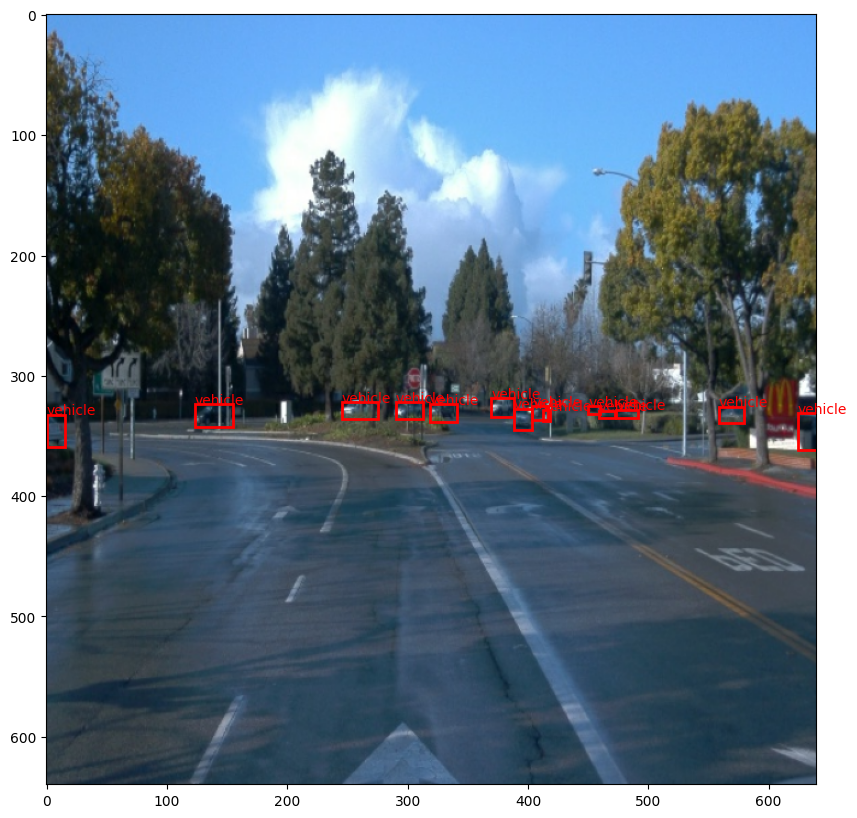

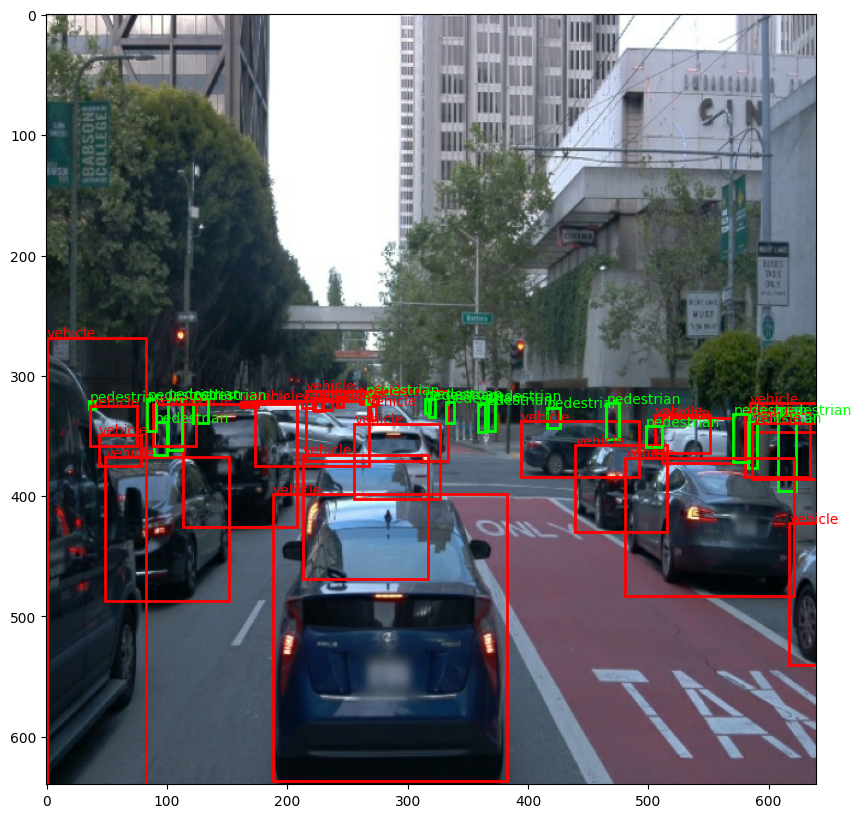

random_crop_image


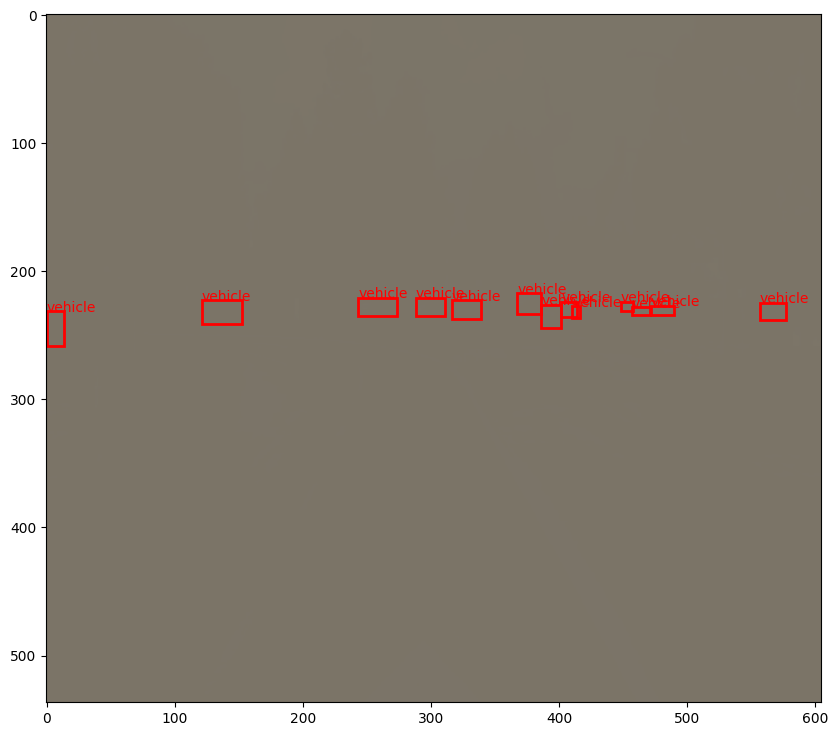

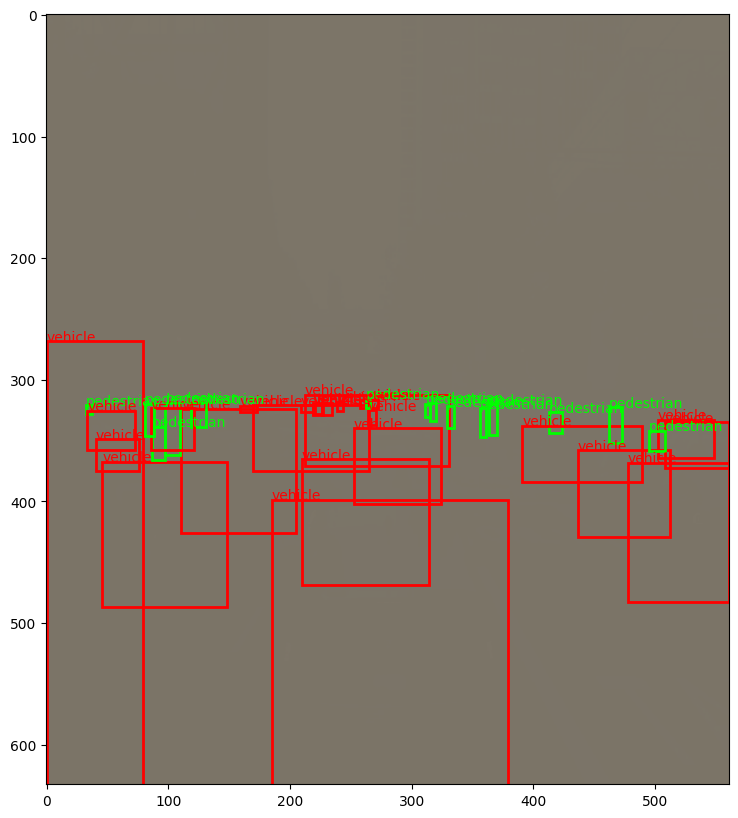

random_image_scale


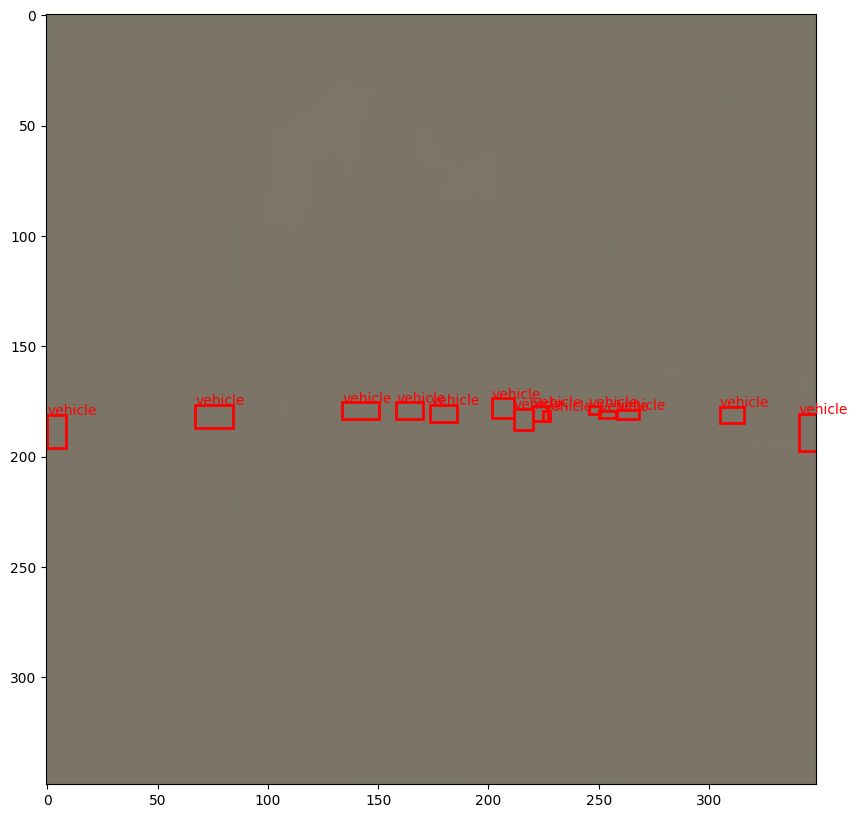

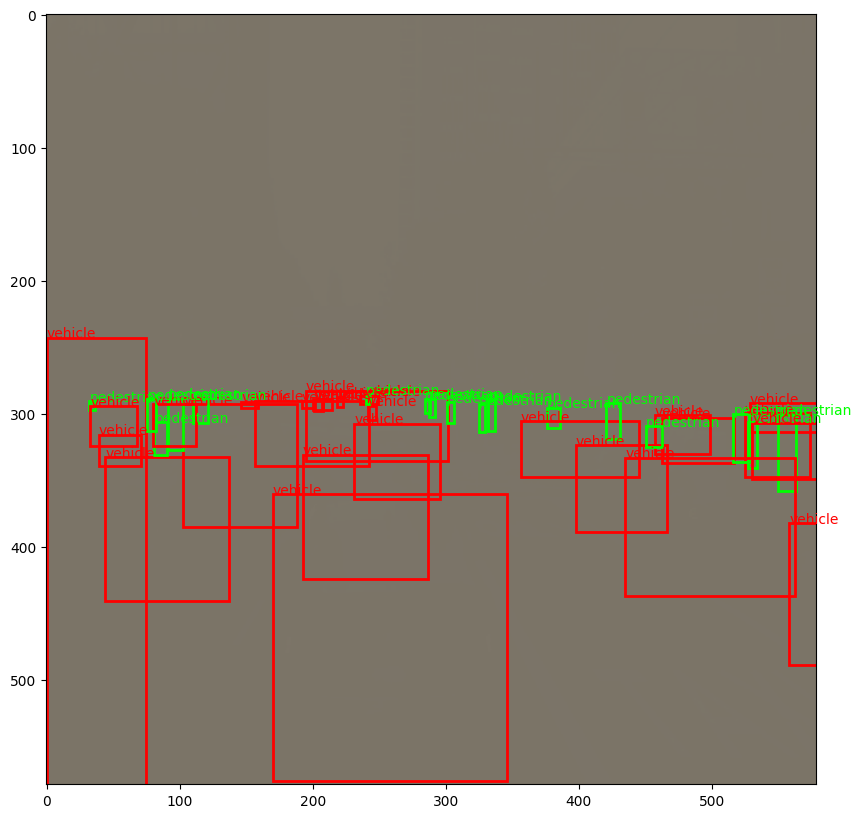

random_downscale_to_target_pixels


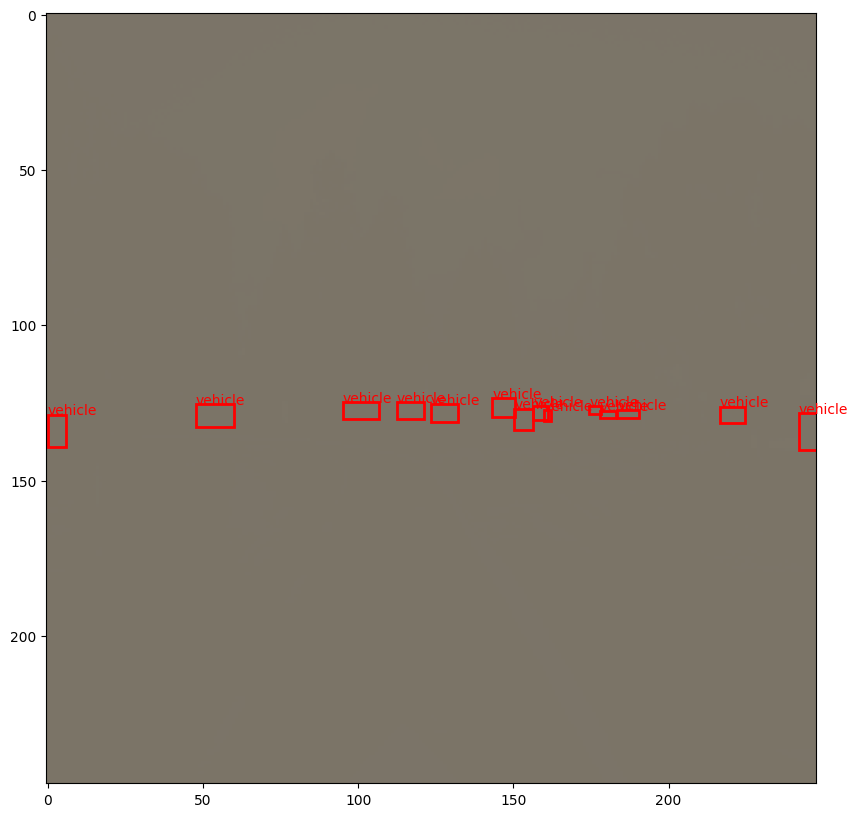

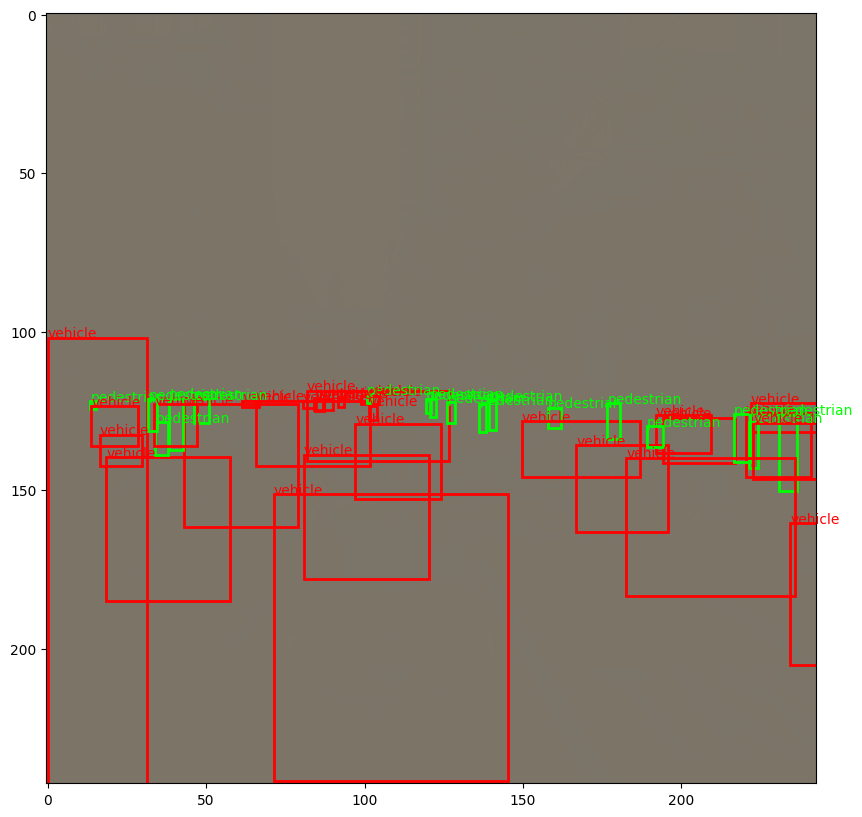

random_adjust_brightness


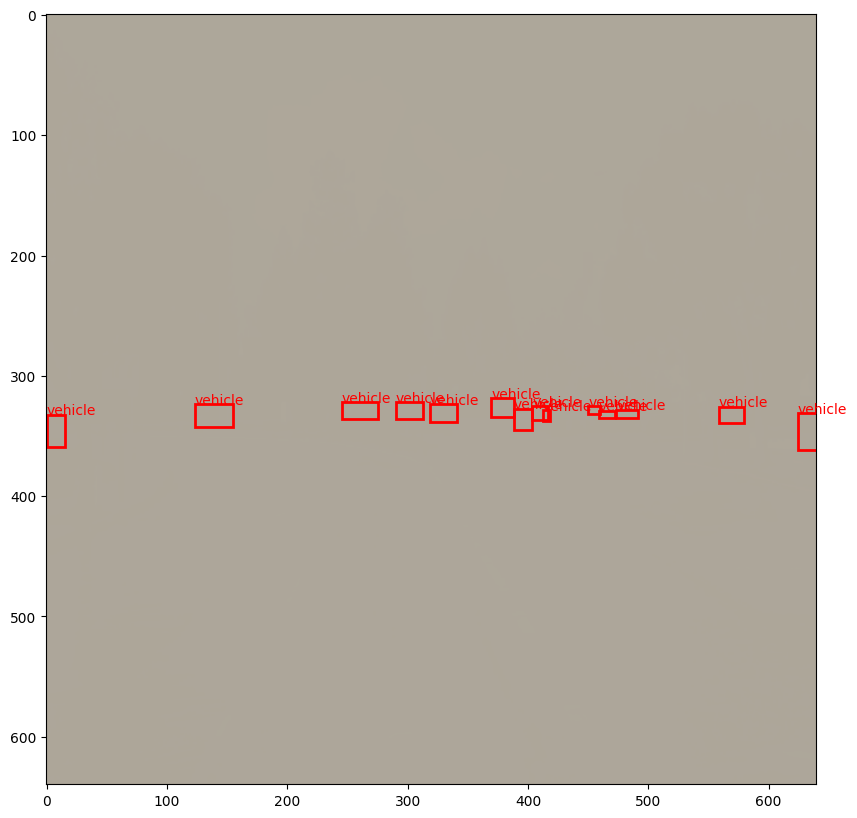

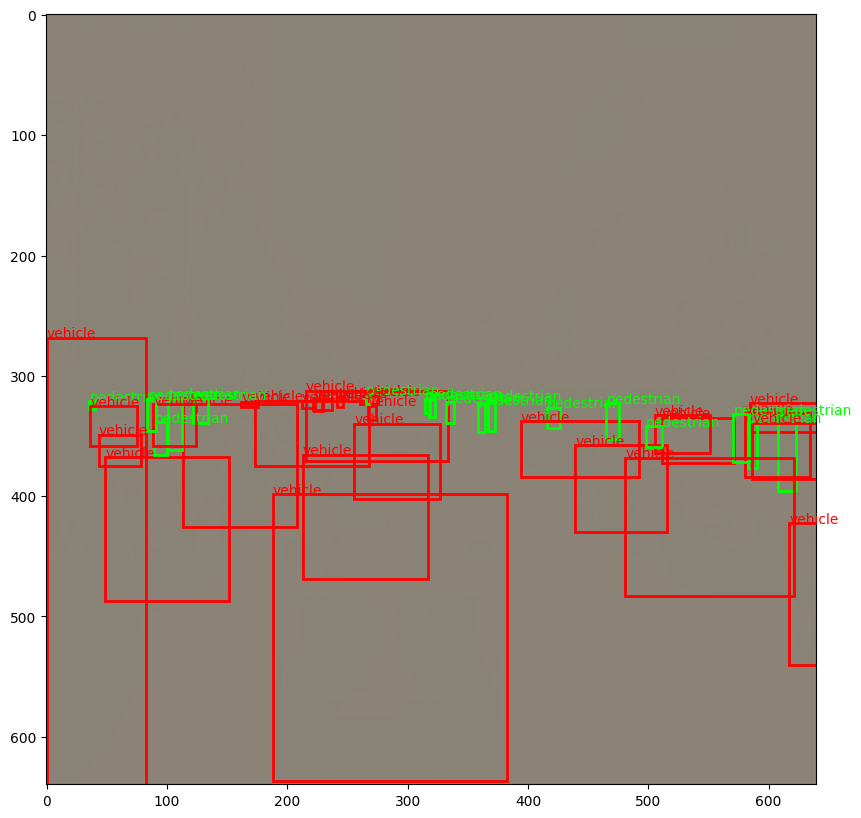

random_scale_crop_and_pad_to_square


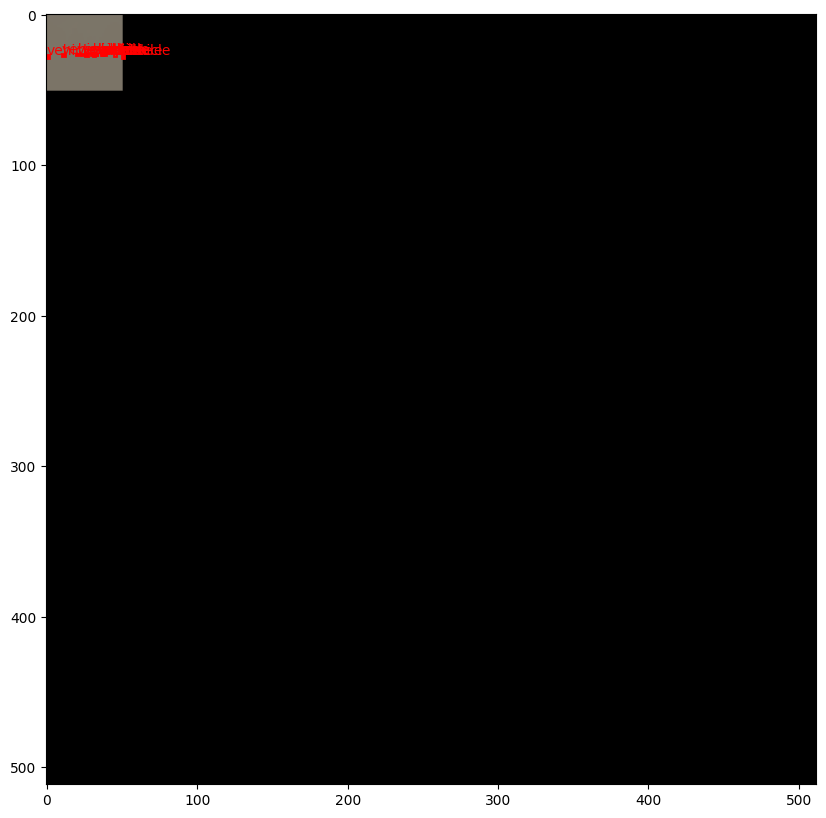

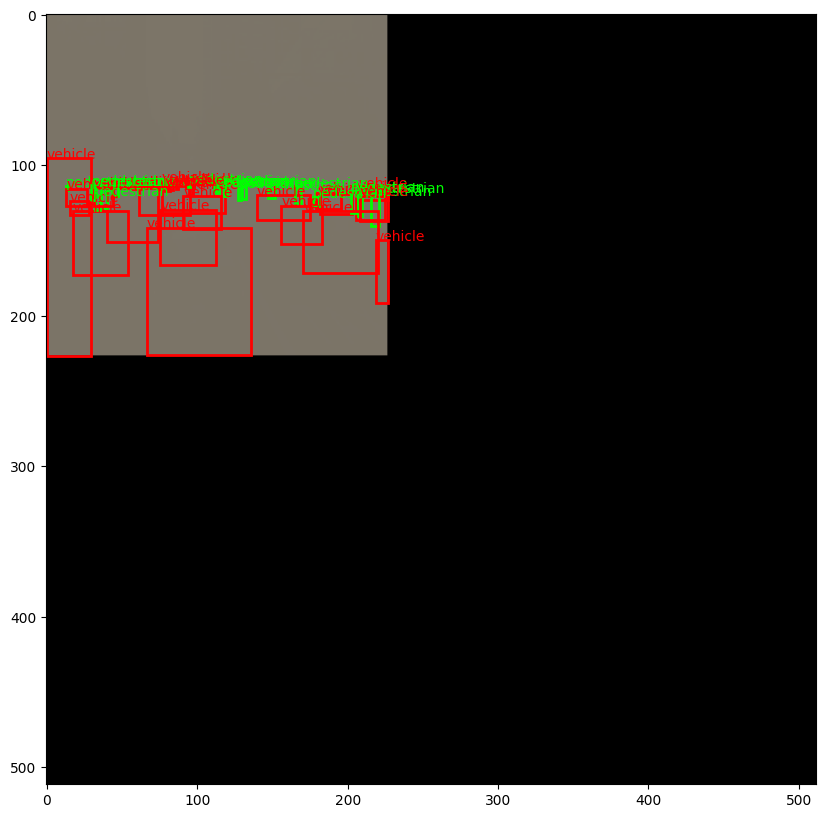

random_pad_image


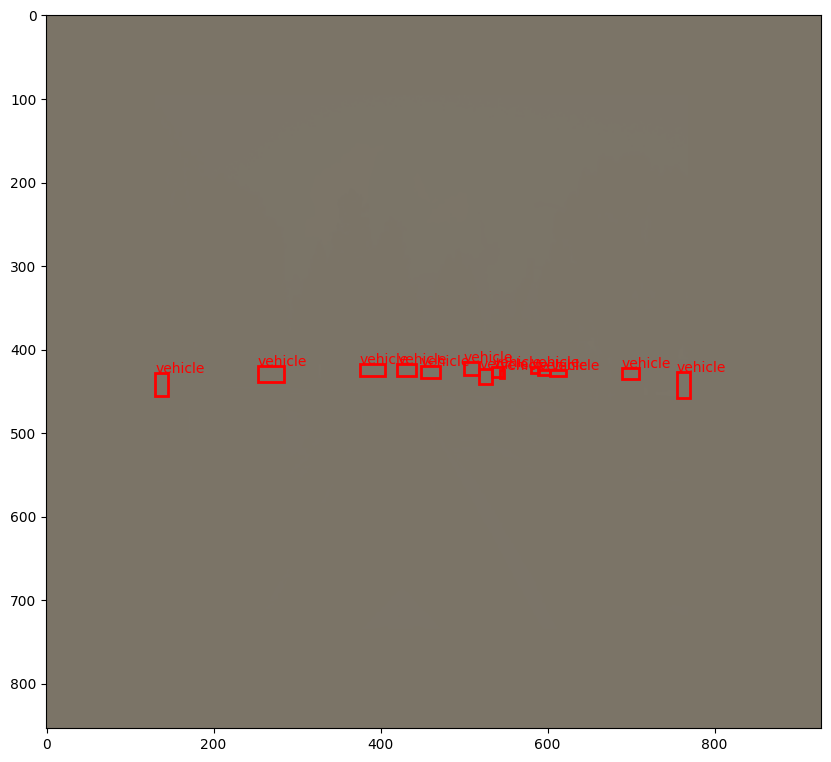

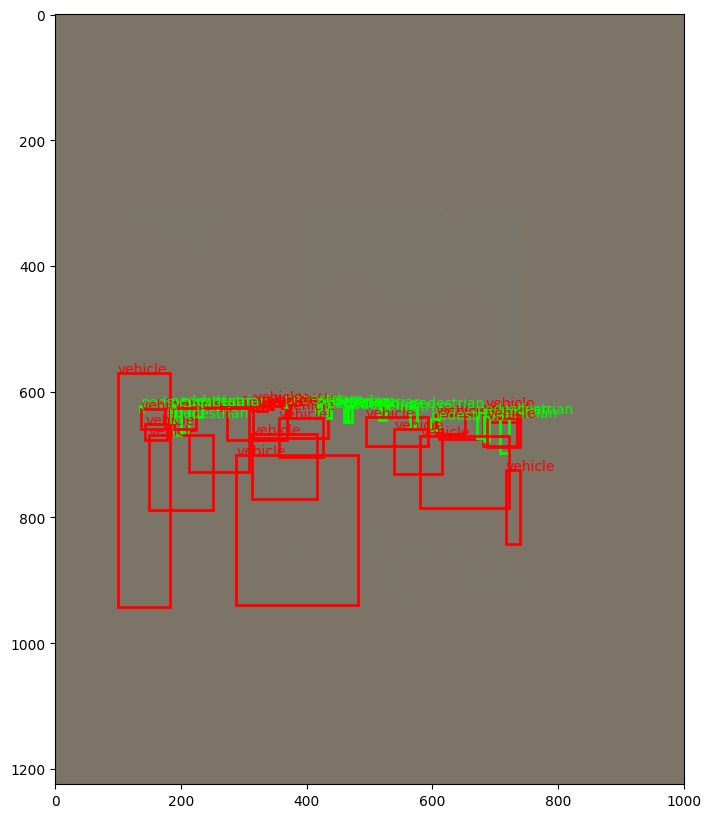

random_black_patches


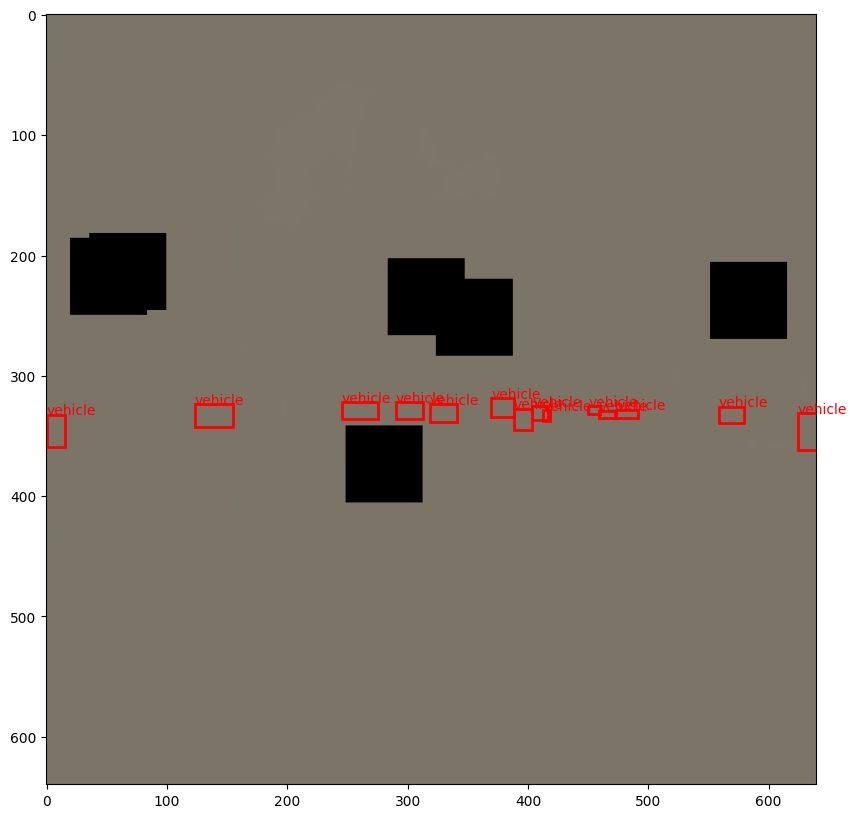

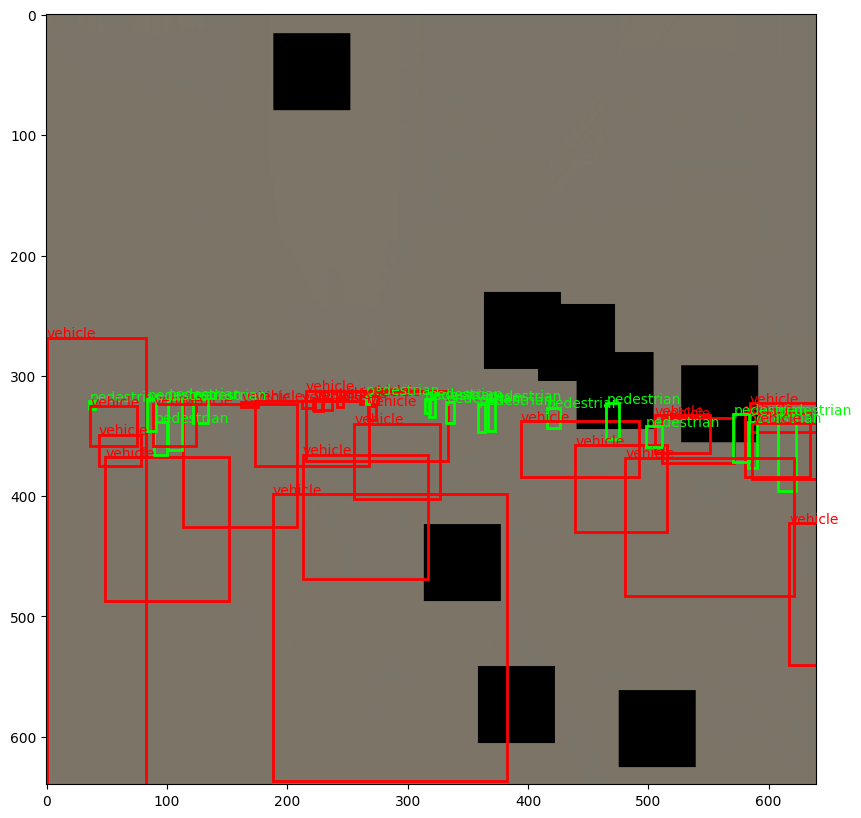

: 

In [22]:
%matplotlib inline
preprocessing_list = [(preprocessor.random_crop_image, {
                            "min_object_covered": 0.0,
                            "aspect_ratio_range": (0.75,3.0),
                            "area_range": (0.75,1.0),
                            "overlap_thresh": 0.0,
                      }),
                      (preprocessor.random_image_scale, {}),
                      (preprocessor.random_downscale_to_target_pixels, {
                          "min_target_pixels": 51200,
                          "max_target_pixels": 76800,
                      }),
                      (preprocessor.random_adjust_brightness, {"max_delta": 0.3}),
                      (preprocessor.random_scale_crop_and_pad_to_square,{}),
                      (preprocessor.random_pad_image, {
                            "min_image_size": 760,
                            "max_image_size": 1280,
                      }),
                      (preprocessor.random_black_patches, {}),
                     ]
for batch in train_dataset.take(1):
        display_batch(batch)
        for preprocessing_fn, params  in preprocessing_list:
            print(preprocessing_fn.__name__)
            for image, boxes, labels, weights, num_bboxes in zip(batch[0]['image'], batch[1]['groundtruth_boxes'], batch[1]['groundtruth_classes'], batch[1]['groundtruth_weights'],batch[1]['num_groundtruth_boxes']):
                if preprocessing_fn.__name__ == preprocessor.random_crop_image.__name__ or preprocessing_fn.__name__ == preprocessor.random_scale_crop_and_pad_to_square.__name__:
                    aug_image, boxes, labels,_ = preprocessing_fn(recenter_image(image),
                                                                                boxes,
                                                                                labels,
                                                                                weights,
                                                                                **params)
                elif preprocessing_fn.__name__ == preprocessor.random_pad_image.__name__ :
                    aug_image, boxes = preprocessing_fn(recenter_image(image), boxes, **params)
                elif preprocessing_fn.__name__ == preprocessor.random_image_scale.__name__:
                    aug_image = preprocessing_fn(recenter_image(image), **params)[0]
                else:
                    aug_image = preprocessing_fn(recenter_image(image), **params)
                batch_augmented = [{'image': tf.expand_dims(decenter_image(aug_image), axis=0)}, {'groundtruth_boxes': tf.expand_dims(boxes, axis=0), 'groundtruth_classes': tf.expand_dims(labels, axis=0), 'groundtruth_weights': tf.expand_dims(weights, axis=0), 'num_groundtruth_boxes': tf.expand_dims(num_bboxes, axis=0)}]
                display_batch(batch_augmented)